In [1]:
import os
import sys
import math
import re
import time
import random
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import cv2
import skimage
import PIL.Image as pilimg
import glob

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

config = coco.CocoConfig()
#coco.py의 114번 째 라인에서 instance_train2014.json의 위치를 직접 지정해 주었다.
COCO_DIR = "" 

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

Using TensorFlow backend.


In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
weights_path = COCO_MODEL_PATH

model.load_weights(weights_path, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [4]:
# Build validation dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")

# Must call before using the dataset
dataset.prepare()
print(config.NAME)
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

,train,2014
loading annotations into memory...
Done (t=11.84s)
creating index...
index created!
/train2014
coco
Images: 82081
Classes: ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush

In [5]:
def revise_mask(image,mask):
    width=image.shape[0]
    height=image.shape[1]
    
    revise_mask=np.zeros((width,height))
    
    for w in range(0, width):
        for h in range(0,height):
            if mask[w,h]==False:
                revise_mask[w,h]=0.0
            else:
                revise_mask[w,h]=255.0
    return revise_mask


In [6]:
def image_merge(image,mask):
    merged_image=np.zeros((256,512,3))
    
    for h in range(0,256):
        for w1 in range(0,256):
            merged_image[h][w1]=image[h][w1]*255

    for h in range(0,256):
        for w2 in range(256,512):
            merged_image[h][w2]=mask[h][w2-256]
    
    
    return merged_image

In [7]:
def bgr2rgb(image):
    wid=image.shape[0]
    hei=image.shape[1]
    
    for w in range(wid):
        for h in range(hei):
            image[w][h][0],image[w][h][2]=image[w][h][2],image[w][h][0]
    return image

In [8]:
def im_trim_molded_resize_using_canny(image,roi_area,mask,num,tar_dir):
    y1=roi_area[0]
    x1=roi_area[1]
    y2=roi_area[2]
    x2=roi_area[3]
    
    width=x2-x1
    height=y2-y1
    
    #gerne영역에 해당하는 이미지와 마스크를 잘라준다.
    img_trim=image[y1:y1+height,x1:x1+width]
    mask_trim=mask[y1:y1+height,x1:x1+width]
    
    img_trim_resize=np.zeros((256,256,3))
    mask_trim_resize=np.zeros((256,256))
    background_make_black_mask=np.zeros((256,256))
    if width>height:
        #비율을 계산해준다.
        t_ratio=256/width
        n_height=int(height*t_ratio)
        
        img_trim_m_resize=skimage.transform.resize(img_trim,(n_height,256),order=1,mode='wrap',cval=0,clip=True,preserve_range=False, anti_aliasing=False,anti_aliasing_sigma=None)
        mask_trim_m_resize=skimage.transform.resize(mask_trim,(n_height,256),order=1,mode='wrap',cval=0,clip=True,preserve_range=False, anti_aliasing=False,anti_aliasing_sigma=None)
        except_black_mask=mask_trim_m_resize.copy()
        
        #이유는 모르겠는데, img_trim_m_resize의 원소 최댓값이 1로 설정되게 
        #resize되므로 이를 255 곱해서 int처리한 것을 cv함수에 넣었더니 depth 오류 발생으로
        #이미지를 한번 저장했다가 다시 불러오는것으로 대체
        t_w,t_h=img_trim_m_resize.shape[:2]
        tmp=np.zeros((t_w,t_h,3))
        for i in range(t_w):
            for j in range(t_h):
                for k in range(3):
                    tmp[i][j][k]=int(img_trim_m_resize[i][j][k]*255)
        cv2.imwrite('tmp.jpg',tmp)
        tmp2=pilimg.open('tmp.jpg')
        tmp2=np.array(tmp2)
        
        grayimage = cv2.cvtColor(tmp2, cv2.COLOR_BGR2GRAY)
        gblur_image=cv2.GaussianBlur(grayimage,(5,5),0)
        canny_image = cv2.Canny(gblur_image, 35, 75) # 35 75
        
        for i in range(t_w):
            for j in range(t_h):
                if mask_trim_m_resize[i][j]==False:
                    continue
                else:
                    if canny_image[i][j]==255:
                        mask_trim_m_resize[i][j]=False
                        
        
        st_point=128-int(n_height/2)
        for i in range(0,n_height):
            for j in range(256):
                img_trim_resize[i+st_point][j]=img_trim_m_resize[i][j]
                mask_trim_resize[i+st_point][j]=mask_trim_m_resize[i][j]
                background_make_black_mask[i+st_point][j]=except_black_mask[i][j]
              
        #이미 img_trim)resize 이미지 생성 시에 0으로 초기화 해줬으므로 불필요한 작업이다.
        #for i in range(n_height,256):
        #    img_trim_resize[i][j]=0
        #    mask_trim_resize[i][j]=0
    
    #height>width
    else:
        t_ratio=256/height
        n_width=int(width*t_ratio)
        
        img_trim_m_resize=skimage.transform.resize(img_trim,(256,n_width),order=1,mode='wrap',cval=0,clip=True,preserve_range=False, anti_aliasing=False,anti_aliasing_sigma=None)
        mask_trim_m_resize=skimage.transform.resize(mask_trim,(256,n_width),order=1,mode='wrap',cval=0,clip=True,preserve_range=False, anti_aliasing=False,anti_aliasing_sigma=None)
        
        '''
        for i in range(256):
            for j in range(0,n_width):
                img_trim_resize[i][j]=img_trim_m_resize[i][j]
                mask_trim_resize[i][j]=mask_trim_m_resize[i][j]
        '''
        
        st_point=128-int(n_width/2)
        for i in range(256):
            for j in range(0,n_width):
                img_trim_resize[i][j+st_point]=img_trim_m_resize[i][j]
                mask_trim_resize[i][j+st_point]=mask_trim_m_resize[i][j]
                
        #이미 img_trim)resize 이미지 생성 시에 0으로 초기화 해줬으므로 불필요한 작업이다.
        #for j in range(n_width,256):
        #    img_trim_resize[i][j]=0
        #    mask_trim_resize[i][j]=0
    
    #원본 이미지와 마스크를 비교하여 마스크에 해당하는 원본 이미지만 살린다. 
    #기존 코드에서는 mask_trim_resize를 그냥 사용해주면 되었지만 canny에 해당하는 부분을 false처리 해서
    #canny에 해당하는 부분도 원래 이미지에서 처리되어 결과가 나와 따로 변수를 만들어
    #mask에 canny를 씌운 것과 기존 mask 두가지를 만들었다.
    for i in range(256):
        for j in range(256):
            if background_make_black_mask[i][j]==0:
                img_trim_resize[i][j]=0
    '''
    #원본 이미지와 마스크를 비교하여 마스크에 해당하는 원본 이미지만 살린다. 
    for i in range(256):
        for j in range(256):
            if mask_trim_resize[i][j]==0:
                img_trim_resize[i][j]=0
    '''
    
    #gerne영역에 대해 trim한 원본 이미지의 차원은 3차원인데 비해 mask의 차원은 1차원이므로 이를 3차원으로 늘려준다.
    z_mask=np.zeros((256,256,3))
    for i in range(256):
        for j in range(256):
            if mask_trim_resize[i][j]==255:
                z_mask[i][j]=255
            else:
                z_mask[i][j]=0
    
    merge_image=image_merge(img_trim_resize,z_mask)

    merge_image=bgr2rgb(merge_image)
    #plt.imshow(merge_image)
    print(tar_dir)
    cv2.imwrite(tar_dir+'{}.jpg'.format(num),merge_image)
    #cv2.imwrite('crop.jpg',merge_image)
    return

In [9]:
#gerne=input("class_id:  ")
#dataset_num=int(input())

#gerne='person'
gerne='car'


In [10]:
#생성할 데이터 셋을 저장할 폴더를 생성한다.
#try except를 활용하여 이미 폴더가 생성되어 있다면 에러를 출력하지 않고 넘어가게 하였다.

target_directory='../sample4/coco'

try:
    if not os.path.isdir(target_directory):
        os.mkdir('dataset_'+gerne)
        #target_directory='../sample4/coco/'+'dataset_'+gerne+'/'
        target_directory='C:/Users/IPCG/Desktop/mask r-cnn _ pix2pix dataset/samples4_pix2pix_dataset/coco/dataset_'+gerne+'/'
        
except FileExistsError:
    #target_directory='../sample4/coco/'+'dataset_'+gerne+'/'
    target_directory='C:/Users/IPCG/Desktop/mask r-cnn _ pix2pix dataset/samples4_pix2pix_dataset/coco/dataset_'+gerne+'/'
    pass

In [11]:
import glob
images=glob.glob('C:/Users/IPCG/Desktop/GAN dataset/pre_car_data/car_dataset/*.jpg')
#images=glob.glob('C:/Users/IPCG/Desktop/person_handmade_dataset/*.jpg')


Processing 1 images
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


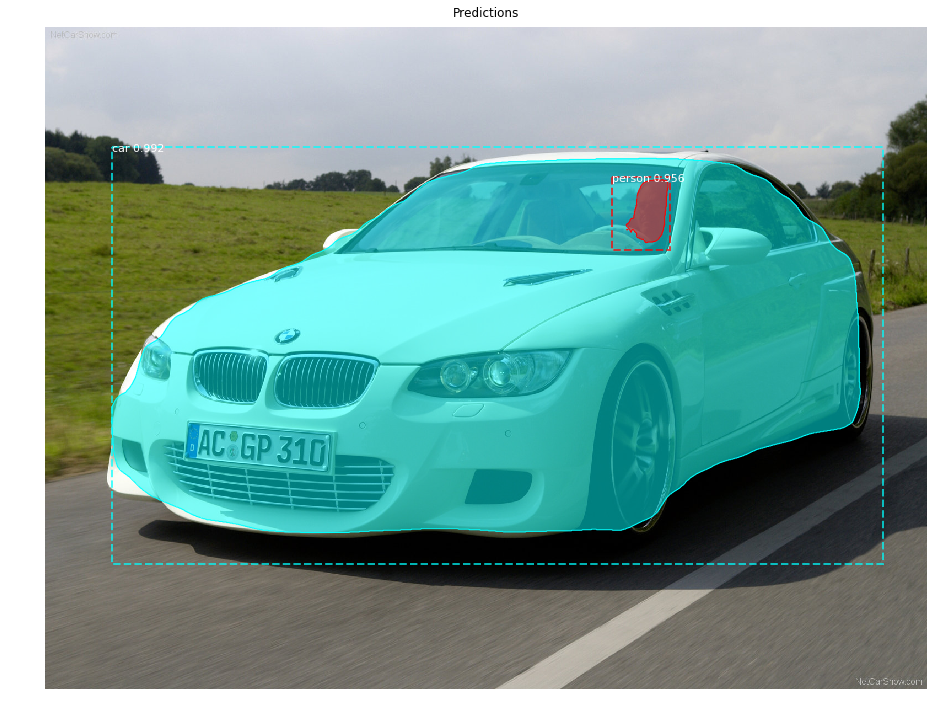

C:/Users/IPCG/Desktop/mask r-cnn _ pix2pix dataset/samples4_pix2pix_dataset/coco/dataset_car/
Processing 1 images
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


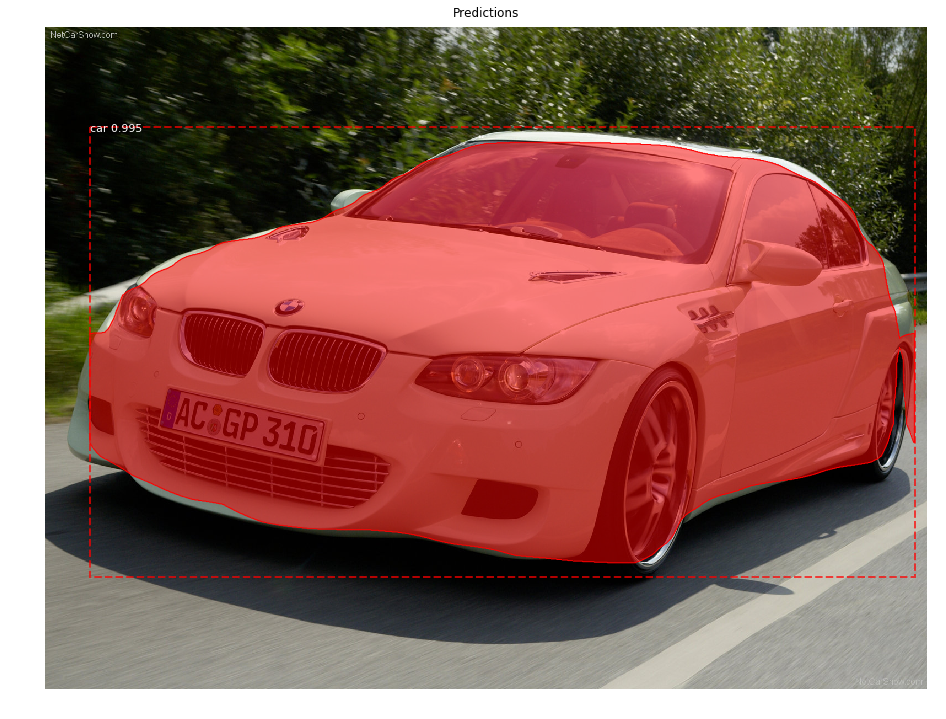

C:/Users/IPCG/Desktop/mask r-cnn _ pix2pix dataset/samples4_pix2pix_dataset/coco/dataset_car/
Processing 1 images
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


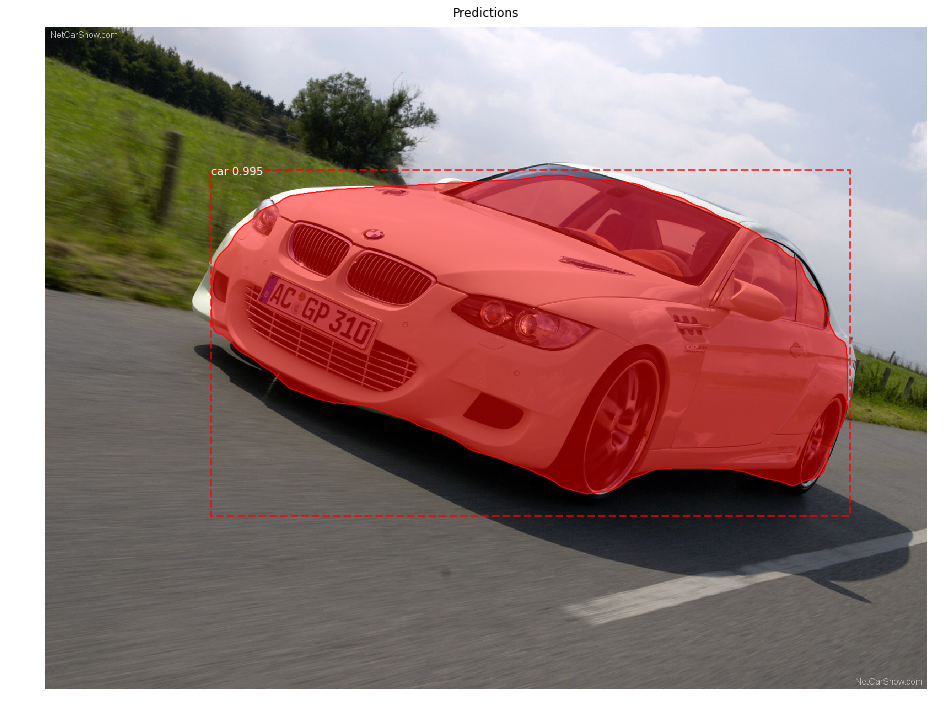

KeyboardInterrupt: 

In [12]:
num=1
for img in images:
    image=pilimg.open(img)
    image=np.array(image)
    
    results = model.detect([image], verbose=1)

    # Display results
    r = results[0]
    
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                        dataset.class_names, r['scores'],
                        title="Predictions")
    
    pre_mask=np.transpose(r['masks'],[2,0,1])
    
    for i in range(len(r['class_ids'])):
        if gerne==dataset.class_names[r['class_ids'][i]]:
            roi_area=r['rois'][i]
            
            r_w=roi_area[3]-roi_area[1]
            r_h=roi_area[2]-roi_area[0]
            
            #if r_w*r_h<65000:
            if r_w*r_h<5000:
                pass
            elif r['scores'][i]<0.9:
                pass
            else:
                rv_pre_mask=revise_mask(image,pre_mask[i])
                im_trim_molded_resize_using_canny(image,roi_area,rv_pre_mask,num,target_directory)
                num+=1 